# Problem 4: Linear regression analysis

A telephone service provider aims to decrease the churn rate and analyses the data and service usage of 1000 clients. The following variables are used in the study

`tenure` - month a client;

`age` - age in years; 

`marital status` - marital status (1 - married, 0 - single); 

`address` - years at the current address; 

`income` - household income in Euro; 

`ed` - education (5 categories: Did not complete high school; High school degree; Some college; College degree; Post-undergraduate degree); 

`retire` - retired (0 - no, 1 - yes); 

`gender` - gender (0 - male, 1 - female); 

`longmon` - long distance calls last month; 

`wiremon` - internet use last month; 

`churn` - 1 if the contract was terminated last month and 0 else

The overall objective is to analyze the service usage using `longmon` as the dependent variables and the remaining variables as explanatory.

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
from utils import *

df_raw = pd.read_csv('data/telco.txt', sep='\t')
N = len(df_raw)
df_raw.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,College degree,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,Did not complete high school,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,High school degree,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,Did not complete high school,2,No,Male,6.30,0.0,No


## 1.

Have a closer look at the deﬁnitions of the variables and analyze which of them might require a separate treatment. Consider for example the variable `ed`. There are two possibilities how the variable `ed` can be included into the model (one with dummy variables, the other one without dummies). Think about these two approaches and suggest which approach is more appropriate. Motivate your decision.

In [3]:
print('Data types:\n{}'.format(df_raw.dtypes))

Data types:
tenure       int64
age          int64
marital     object
address      int64
income       int64
ed          object
employ       int64
retire      object
gender      object
longmon    float64
wiremon    float64
churn       object
dtype: object


In [4]:
# Group variables by the type of the scale
intervals = list(df_raw.dtypes[(df_raw.dtypes == np.int64) | 
                               (df_raw.dtypes == np.float64)].index)
          # ['tenure', 'age', 'address', 'income',
          #  'employ', 'longmon', 'wiremon']
    
ordinals = ['ed']

nominals = list(set(df_raw.dtypes.index).difference(intervals, ordinals))
          # ['marital', 'retire', 'gender', 'churn']

df_intervals = df_raw[intervals]
df_ordinals = df_raw[ordinals]
df_nominals = df_raw[nominals]

In [5]:
# Look at interval scaled variables
stats_descr = sp.stats.describe(df_intervals)
describe_intervals = df_intervals.describe(percentiles=[.1, .25, .5, .75, .9]).append(
    [pd.Series(stats_descr.skewness, index=intervals, name='skew'),
     pd.Series(stats_descr.variance, index=intervals, name='var')])
describe_intervals = describe_intervals.drop('count',0)
describe_intervals

,tenure,age,address,income,employ,longmon,wiremon
mean,35.526000,41.684000,11.551000,77.535000,10.987000,11.723100,11.583900
std,21.359812,12.558816,10.086681,107.044165,10.082087,10.363486,19.719426
min,1.000000,18.000000,0.000000,9.000000,0.000000,0.900000,0.000000
10%,7.000000,26.000000,1.000000,21.000000,0.000000,3.645000,0.000000
25%,17.000000,32.000000,3.000000,29.000000,3.000000,5.200000,0.000000
50%,34.000000,40.000000,9.000000,47.000000,8.000000,8.525000,0.000000
75%,54.000000,51.000000,18.000000,83.000000,17.000000,14.412500,24.712500
90%,66.000000,59.000000,26.100000,155.400000,25.000000,23.960000,42.110000
max,72.000000,77.000000,55.000000,1668.000000,47.000000,99.950000,111.950000
skew,0.111692,0.356128,1.104586,6.633303,1.059457,2.961653,1.601274


In [6]:
# Look at nominal scaled variables
df_nominals.describe()

,marital,gender,retire,churn
count,1000,1000,1000,1000
unique,2,2,2,2
top,Unmarried,Female,No,No
freq,505,517,953,726


In [7]:
# Look at ordinal scaled variables
df_ordinals.describe()

,ed
count,1000
unique,5
top,High school degree
freq,287


> The variable `ed` can be represented as dummy variables:

In [8]:
ed_dummies = pd.get_dummies(df_raw.ed)
ed_names_dict = {'College degree': 'ed_college',
                 'Did not complete high school': 'ed_no',
                 'High school degree': 'ed_highschool',
                 'Post-undergraduate degree': 'ed_postgr',
                 'Some college': 'ed_somecollege'}
ed_dummies = ed_dummies.rename(columns=ed_names_dict).drop(['ed_no'], 1)
ed_dummies.head()

,ed_college,ed_highschool,ed_postgr,ed_somecollege
1,1,0,0,0
2,0,0,1,0
3,0,0,0,0
4,0,1,0,0
5,0,0,0,0


In [9]:
df_dummies = pd.concat((df_raw.drop('ed', 1), ed_dummies), 1)
df_dummies['marital'] = df_dummies.marital.map(dict(Married=1, Unmarried=0))
df_dummies['retire'] = df_dummies.retire.map(dict(Yes=1, No=0))
df_dummies['gender'] = df_dummies.gender.map(dict(Female=1, Male=0))
df_dummies['churn'] = df_dummies.churn.map(dict(Yes=1, No=0))
df_dummies.head()

,tenure,age,marital,address,income,employ,retire,gender,longmon,wiremon,churn,ed_college,ed_highschool,ed_postgr,ed_somecollege
1,13,44,1,9,64,5,0,0,3.70,0.0,1,1,0,0,0
2,11,33,1,7,136,5,0,0,4.40,35.7,1,0,0,1,0
3,68,52,1,24,116,29,0,1,18.15,0.0,0,0,0,0,0
4,33,33,0,12,33,0,0,1,9.45,0.0,1,0,1,0,0
5,23,30,1,9,30,2,0,0,6.30,0.0,0,0,0,0,0


> Another option is to use the property of the order scaled variable and map the values to their ranks:

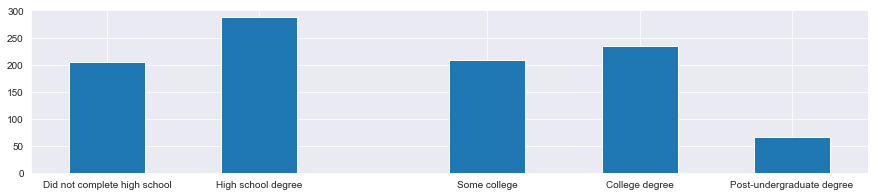

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,3,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,4,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,0,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,1,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,0,2,No,Male,6.30,0.0,No


In [10]:
ed_order_dict = {'Did not complete high school': 0,
                 'High school degree': 1,
                 'Some college': 2,
                 'College degree': 3,
                 'Post-undergraduate degree': 4}
df_ordered = df_raw.copy()
df_ordered['ed'] = df_ordered.ed.map(ed_order_dict)
mpl.rcParams['figure.figsize'] = (15, 3)
plt.hist(df_ordered.ed, align='mid')
plt.xticks([0.2,1,2.2,3,3.8], ed_order_dict.keys())
plt.show()
df_ordered.head()

> On the one hand, the second approach should be more appropriate since we include the information about the order of `ed` e.g. some education is better or higher than no education at all.
>
> On the other hand with this order we "fix" the difference between degrees and say e.g. that `Post-undergraduate degree` is higher than `College degree` as much as `Some college` is higher than `High school degree` etc. while this may not be true. But with dummy variables this is not fixed, so it is suggested to use futher.

In [11]:
df = df_dummies.copy()

## 2.

Consider now the dependent variable `longmon` and the interval (metric) scaled explanatory variables. Plot these data and decide if you wish to transform these x-variables and if there is a need to transform the y variable. You can also use some measure of skewness to decide about y. The variable `wiremon` shows a very speciﬁc pattern. How would you take it into account?

In [12]:
mpl.rcParams['figure.figsize'] = (17,5)

#### `longmon` (long distance calls last month)

Variable `longmon`
Number of observations: 1000


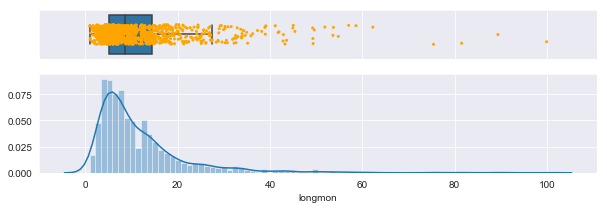

mean     11.723100
std      10.363486
min       0.900000
10%       3.645000
25%       5.200000
50%       8.525000
75%      14.412500
90%      23.960000
max      99.950000
skew      2.961653
var     107.401848
Name: longmon, dtype: float64
The distribution is right-skewed.


In [12]:
column = 'longmon'
represent_distribution(df[column], varname=column)
print(describe_intervals.longmon)
skewness = sp.stats.skew(df[column])
print('The distribution is {}.'.format('right-skewed' if skewness > 0 else 'left-skewed'))

> We transform this variable `longmon` into `log(longmon)`:

Variable `log_longmon`
Number of observations: 1000


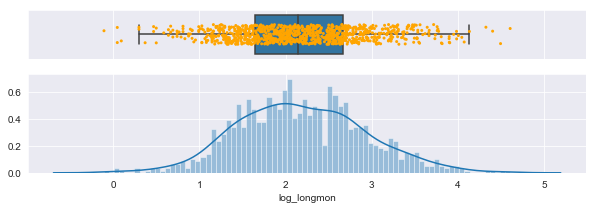

In [13]:
df['log_{}'.format(column)] = np.log(df[column])
column = 'log_{}'.format(column)
represent_distribution(df[column], varname=column)
# stats_descr = sp.stats.describe(df[['log_longmon']])
# df[['log_longmon']].describe(percentiles=[.1, .25, .5, .75, .9]).append(
# [pd.Series(stats_descr.skewness, index=['log_longmon'], name='skew'),
# pd.Series(stats_descr.variance, index=['log_longmon'], name='var')]).drop('count',0)

#### `tenure`

Variable `tenure`
Number of observations: 1000


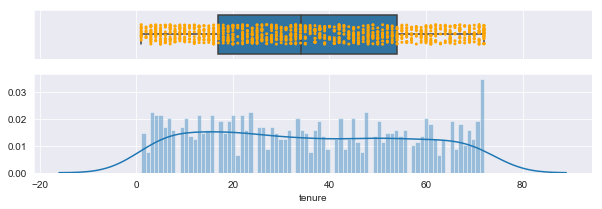

mean     35.526000
std      21.359812
min       1.000000
10%       7.000000
25%      17.000000
50%      34.000000
75%      54.000000
90%      66.000000
max      72.000000
skew      0.111692
var     456.241566
Name: tenure, dtype: float64


In [14]:
column = 'tenure'
represent_distribution(df[column], varname=column)
print(describe_intervals[column])

#### `age` (age in years)

Variable `age`
Number of observations: 1000


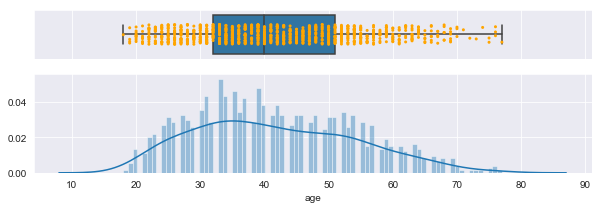

mean     41.684000
std      12.558816
min      18.000000
10%      26.000000
25%      32.000000
50%      40.000000
75%      51.000000
90%      59.000000
max      77.000000
skew      0.356128
var     157.723868
Name: age, dtype: float64


In [15]:
column = 'age'
represent_distribution(df[column], varname=column)
print(describe_intervals[column])

#### `address` (years at the current address)

Variable `address`
Number of observations: 1000


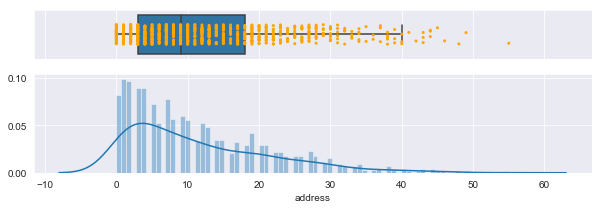

mean     11.551000
std      10.086681
min       0.000000
10%       1.000000
25%       3.000000
50%       9.000000
75%      18.000000
90%      26.100000
max      55.000000
skew      1.104586
var     101.741140
Name: address, dtype: float64


In [13]:
column = 'address'
represent_distribution(df[column], varname=column)
print(describe_intervals[column])

Variable `address`
Number of observations: 1000


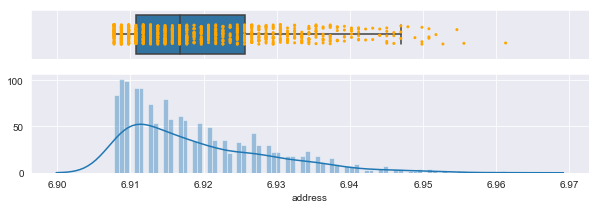

In [26]:
represent_distribution(np.log(df[column]+1000), varname=column)

#### `income` (household income in Euro)

Variable `income`
Number of observations: 1000


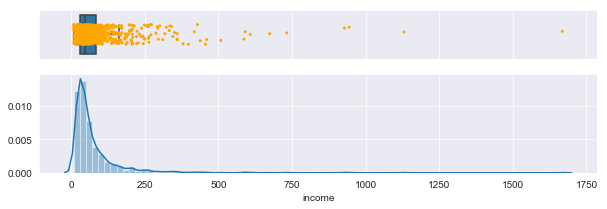

mean       77.535000
std       107.044165
min         9.000000
10%        21.000000
25%        29.000000
50%        47.000000
75%        83.000000
90%       155.400000
max      1668.000000
skew        6.633303
var     11458.453228
Name: income, dtype: float64


In [17]:
column = 'income'
represent_distribution(df[column], varname=column)
print(describe_intervals[column])

> As with `longmon` we transform the variable `income` into `log(income)`:

Variable `log_income`
Number of observations: 1000


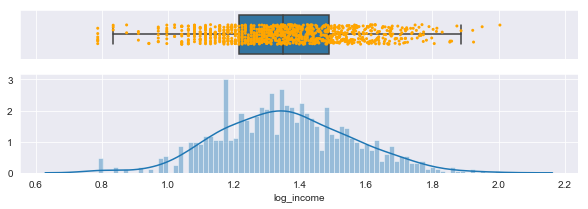

In [18]:
df['log_{}'.format(column)] = np.log(df[column])
column = 'log_{}'.format(column)
represent_distribution(np.log(df[column]), varname=column)

#### `employ` (years with the current employer)

Variable `employ`
Number of observations: 1000


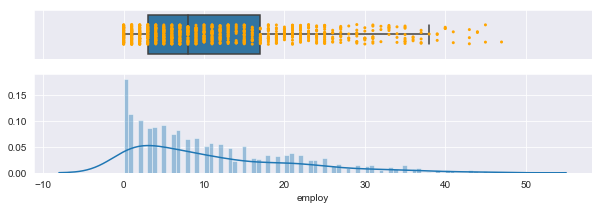

mean     10.987000
std      10.082087
min       0.000000
10%       0.000000
25%       3.000000
50%       8.000000
75%      17.000000
90%      25.000000
max      47.000000
skew      1.059457
var     101.648479
Name: employ, dtype: float64


In [19]:
column = 'employ'
represent_distribution(df[column], varname=column)
print(describe_intervals[column])

#### `wiremon` (internet use last month)

Variable `wiremon`
Number of observations: 1000


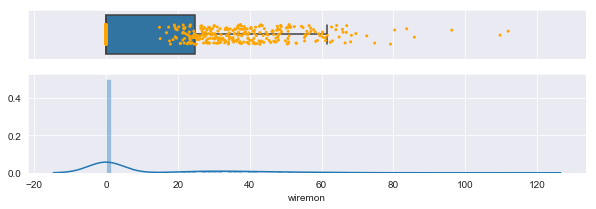

mean     11.583900
std      19.719426
min       0.000000
10%       0.000000
25%       0.000000
50%       0.000000
75%      24.712500
90%      42.110000
max     111.950000
skew      1.601274
var     388.855747
Name: wiremon, dtype: float64


In [20]:
column = 'wiremon'
represent_distribution(df[column], varname=column)
print(describe_intervals[column])

> Let's look at the distribution of usage for those who used the internet last month:

Variable `wiremon > 0`
Number of observations: 296


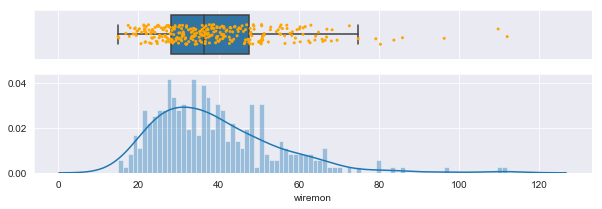

In [21]:
represent_distribution(df[df[column]>0][column], varname=column+' > 0')

> We can create a dummy variable representing, whether the client used or not the internet last month:

In [22]:
df['wire_not_used'] = (df['wiremon']==0).astype(np.int)
nominals.append('wire_not_used')

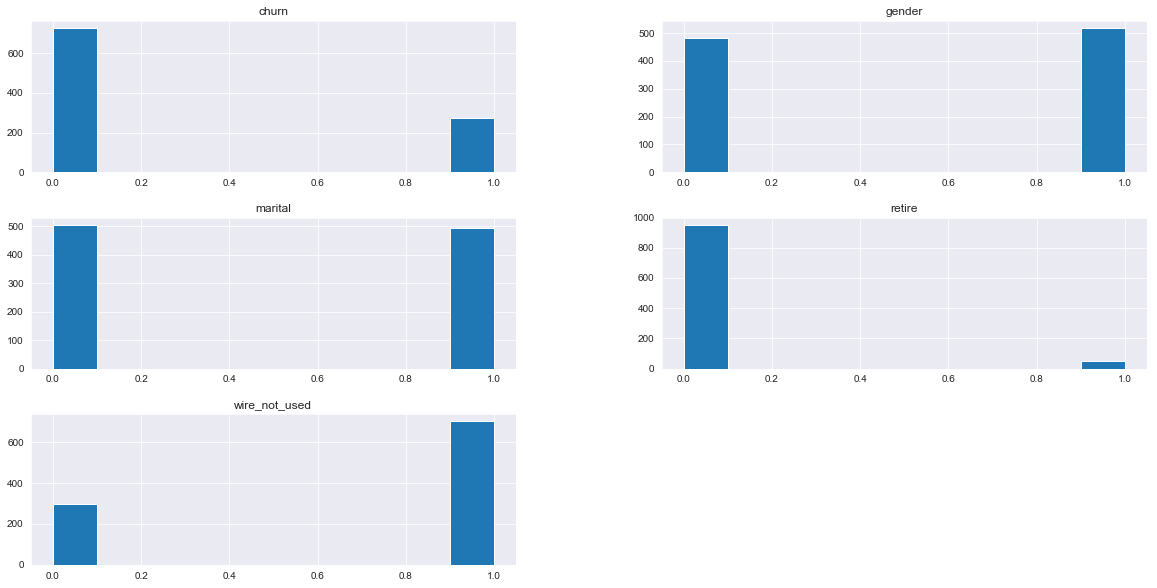

In [487]:
df[nominals].hist(figsize=(20, 10))
plt.show()

In [24]:
df.head()

,tenure,age,marital,address,income,employ,retire,gender,longmon,wiremon,churn,ed_college,ed_highschool,ed_postgr,ed_somecollege,log_longmon,log_income,wire_not_used
1,13,44,1,9,64,5,0,0,3.70,0.0,1,1,0,0,0,1.308333,4.158883,1
2,11,33,1,7,136,5,0,0,4.40,35.7,1,0,0,1,0,1.481605,4.912655,0
3,68,52,1,24,116,29,0,1,18.15,0.0,0,0,0,0,0,2.898671,4.753590,1
4,33,33,0,12,33,0,0,1,9.45,0.0,1,0,1,0,0,2.246015,3.496508,1
5,23,30,1,9,30,2,0,0,6.30,0.0,0,0,0,0,0,1.840550,3.401197,1


## 3.

After making up your decision about the above two problems run a simple linear regression.

In [25]:
def R_squared(y, y_hat):
    y = np.array(y).reshape(-1,1)
    y_hat = np.array(y_hat).reshape(-1,1)
    y_mean = y.mean()
    ESS = np.linalg.norm(y_hat - y_mean)**2
    TSS = np.linalg.norm(y - y_mean)**2
    return ESS/TSS

def R_squared_adj(y, y_hat, K):
    y = np.array(y).reshape(-1,1)
    y_hat = np.array(y_hat).reshape(-1,1)
    N = len(y)
    y_mean = y.mean()
    RSS = np.linalg.norm(y - y_hat)**2
    TSS = np.linalg.norm(y - y_mean)**2
    return 1 - RSS * (N-1) / (TSS * (N-K-1))

def AIC(y, y_hat, K):
    y = np.array(y).reshape(-1,1)
    y_hat = np.array(y_hat).reshape(-1,1)
    u = y - y_hat
    s2 = np.var(u, ddof=1)
    N = len(y)
    return np.log(s2) + 2 * K / N

def BIC(y, y_hat, K):
    y = np.array(y).reshape(-1,1)
    y_hat = np.array(y_hat).reshape(-1,1)
    u = y - y_hat
    N = len(y)
    s2 = np.var(u, ddof=1)
    return np.log(s2) + K * np.log(N) / N

In [26]:
def get_X_y(df, regressand, regressors, out=True):
    if out:
        print('Regressand:', regressand)
        print('Regressors:', regressors)
    y = df[regressand]
    X = df[regressors]
    return X, y

def get_normalized_X_y(X, y, intervals_regressors):
    X_intervals_means = X[intervals_regressors].mean()
    X_intervals_stds = X[intervals_regressors].std(ddof=1)

    X_norm = X.copy()
    X_norm[intervals_regressors] = (X[intervals_regressors] - X_intervals_means) / X_intervals_stds

    y_mean = y.mean()
    y_std = y.std(ddof=1)
    y_norm = (y - y_mean) / y_std
    
    return X_norm, y_norm, X_intervals_means, X_intervals_stds, y_mean, y_std

def get_LR_beta(X, y, out_scores=False):
    LR = linear_model.LinearRegression()
    LR.fit(X, y)
    beta_df = pd.DataFrame([LR.intercept_]+list(LR.coef_),
                           index=X.columns.insert(0, 1),
                           columns=['coef'])
    if out_scores:
        print('LR scores:')
        get_scores(LR, X, y)
    return LR, beta_df

def get_scores(LR, X, y):
    # y_hat = np.dot(sm.add_constant(X), beta_df['coef'].values.reshape(-1,1))
    y_hat = LR.predict(X)
    R2 = R_squared(y, y_hat)
    R2adj = R_squared_adj(y, y_hat, K)
    aic = AIC(y, y_hat, K)
    bic = BIC(y, y_hat, K)
    print('R^2 = {:.3f}\nR^2_adj = {:.3f}\nAIC = {:.3f}\nBIC = {:.3f}'.format(R2, R2adj, aic, bic))
    
def get_standardized_coef(beta_df_orig, intervals_regressors, other_regressors):
    # For self-check
    beta_df = beta_df_orig.copy()
    beta_df['coef_st'] = beta_df['coef']
    beta_df.loc[intervals_regressors,'coef_st'] = beta_df.loc[intervals_regressors,'coef'] * X_intervals_stds / y_std
    beta_df.loc[other_regressors,'coef_st'] = beta_df.loc[other_regressors,'coef'] / y_std
    beta_df.loc[1,'coef_st'] = (beta_df.loc[1,'coef'] + np.sum(beta_df.loc[intervals_regressors,'coef'] * X_intervals_means) - y_mean) / y_std
    return beta_df

In [707]:
# Simple LR
regressand = 'log_longmon'
# with wiremon
# regressors = sorted(list(set(df.columns).difference({'longmon', 'log_longmon', 'income', 'wire_used'})))
# intervals_regressors = sorted(list(set(intervals).union({'log_income'}).difference({'longmon', 'income'})))

# with wire_used
regressors = sorted(list(set(df.columns).difference({'longmon', 'log_longmon', 'income', 'wiremon'})))
intervals_regressors = sorted(list(set(intervals).union({'log_income'}).difference({'longmon', 'income', 'wiremon'})))
other_regressors = sorted(list(set(regressors).difference(intervals_regressors)))

X, y = get_X_y(df, regressand, regressors)
K = X.shape[1]

Regressand: log_longmon
Regressors: ['address', 'age', 'churn', 'ed_college', 'ed_highschool', 'ed_postgr', 'ed_somecollege', 'employ', 'gender', 'log_income', 'marital', 'retire', 'tenure', 'wire_not_used']


> Before runing LR we normalize $X$ and $y$, and work only with it. As will be shown in Problem 5, it won't affect $R^2$ and we can get coefficients for the unnormalized data with corresponding linear transformtions. 

In [709]:
X, y, X_intervals_means, X_intervals_stds, y_mean, y_std = \
                            get_normalized_X_y(X, y, intervals_regressors)
X_ = sm.add_constant(X)

LR, beta_df = get_LR_beta(X, y)
beta_df['coef_abs'] = np.abs(beta_df['coef'])

# Get standardized coefficients of LR
# LR_st, beta_df = get_LR_beta(X_norm, y_norm, True)
# beta_df['coef_st'] = beta_st['coef']
# beta_df['coef_st_abs'] = np.abs(beta_df['coef_st'])
print('\nStandardized LR coefficients:')
print(beta_df.sort_values(by='coef_abs',  ascending=False)[['coef']])
print()
y_hat = LR.predict(X)
print('R_squared: {:.3f}'.format(R_squared(y, y_hat)))
print('R_squared_adj: {:.3f}'.format(R_squared_adj(y, y_hat, K)))
print('AIC: {:.3f}'.format(AIC(y, y_hat, K)))
print('BIC: {:.3f}'.format(BIC(y, y_hat, K)))

LR = sm.OLS(y, X_)
LR_results = LR.fit()
# print(LR_results.summary())


Standardized LR coefficients:
                    coef
tenure          0.793197
retire          0.334490
ed_college      0.157259
1              -0.126201
ed_highschool   0.124676
ed_somecollege  0.108959
marital         0.098148
churn          -0.054113
address         0.051514
gender         -0.048634
age            -0.047336
employ          0.024508
log_income      0.023402
ed_postgr       0.012869
wire_not_used   0.008047

R_squared: 0.717
R_squared_adj: 0.713
AIC: -1.235
BIC: -1.167


If you wish to argue that `education` is insigniﬁcant and use the model with dummies then you have to check the simultaneous insigniﬁcance of all dummies which stem from the factor variable `ed`. Run a test for general linear hypothesis and conclude about the signiﬁcance of `ed`.

> Variable `ed` seems to be important, let's check it:

In [31]:
ed_vars = ['ed_somecollege', 'ed_college', 'ed_highschool', 'ed_postgr']

def test_significance(LR_results, variabless):
    H0 = ' = '.join(variabless) + ' = 0'
    if len(variabless) > 1:
        H0_text = 'all in {} simultaneously have no impact'.format(variabless)
        H1_text = 'at least one in {} is significant'.format(variabless)
    else:
        H0_text = '{} has no impact'.format(variabless)
        H1_text = '{} is significant'.format(variabless)
    print('H0:', H0_text)
    print('H1:', H1_text)

    F_results = LR_results.f_test(H0)
    print('F = {:.4f}, p-value = {:.4f}'.format(F_results.fvalue[0,0], F_results.pvalue))
    
test_significance(LR_results, ed_vars)    

H0: all in ['ed_somecollege', 'ed_college', 'ed_highschool', 'ed_postgr'] simultaneously have no impact
H1: at least one in ['ed_somecollege', 'ed_college', 'ed_highschool', 'ed_postgr'] is significant
F = 2.7484, p-value = 0.0272


> The p-value is small enough so we decide to reject H0, which means that the variable `education` is significant.

## 4.

Provide an economic interpretation for the parameters of `address`, `ed`, and `retire`. Neglect the possible insigniﬁcance and keep in mind possible transformations of the variables.

In [32]:
beta_df.loc[['address', 'retire',
             'ed_somecollege','ed_college',
             'ed_highschool', 'ed_postgr'], :]\
.sort_values(by='coef_abs', ascending=False)[['coef']]

,coef
retire,0.334490
ed_college,0.157259
ed_highschool,0.124676
ed_somecollege,0.108959
address,0.051514
ed_postgr,0.012869


Address mean: -0.00, std: 1.00 (used for normalization)
Variable `normalized address`
Number of observations: 1000


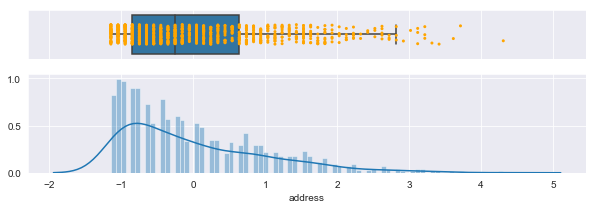

H0: ['address'] has no impact
H1: ['address'] is significant
F = 4.6722, p-value = 0.0309

H0: ['retire'] has no impact
H1: ['retire'] is significant
F = 9.5569, p-value = 0.0020


In [33]:
print('Address mean: {:.2f}, std: {:.2f} (used for normalization)'.format(X_intervals_means['address'], X_intervals_stds['address']))
represent_distribution(X['address'], varname='normalized address')
test_significance(LR_results, ['address'])
print()
test_significance(LR_results, ['retire'])

> The p-value for the first test with `address` is small so this variable is significant. This variable represents years at the current address but during the normalization $11.5$ was subtracted from values and it was divided by $10$ so now it's hard to interpret this variable.
> The p-value for the test with `retire` is also very small so this variable is significant. It is a nominal scaled variable representing whether a person is retired or not, and it wasn't changed. The coefficient $0.3345$ tells that with the same other parameters change from 'not retired' to 'retired' would make us expect an increasing in normalized `log_longmon` by $0.3345$.
> For `education` we already concluded that it is a significant variable. It represents type of education and, as was supposed, we see that indeed a change on different education levels causes a different change in target, and also the order of (sorted) coefficients is not the same as a natural order of education levels (where e.g. `college` should be between `highschool` and `postgr`) so the relation is more complex.

## 5.

Compute the 95% conﬁdence intervals for the parameters of `address` and `income` and provide its economic meaning. Relate the CIs to the tests of signiﬁcance, i.e. how would you use these intervals to decide about the signiﬁcance of the corresponding explanatory variables? The CIs are computed relying on the assumption, that the residuals follow normal distribution. Is this assumption fulfilled? Run an appropriate goodness-of-fit test.

In [34]:
print('95%-CI:')
CI = LR_results.conf_int(alpha=0.05).loc[['address', 'log_income'], :]\
          .rename(columns={0:'lower', 1:'upper'})
CI['length'] = CI.upper - CI.lower
print(CI)
print()
test_significance(LR_results, ['log_income'])

95%-CI:
               lower     upper    length
address     0.004746  0.098283  0.093537
log_income -0.033571  0.080375  0.113946

H0: ['log_income'] has no impact
H1: ['log_income'] is significant
F = 0.6497, p-value = 0.4204


> The lower bound for the `log_income` is negative, the upper bound is positive. So zero value for the coefficient is inside 95% confidence interval which mean possible insignificance of the variable. The significance test results in quite large p-value 0.42, so we can reject the null-hypothesis (stating that the variable is significant) and drop `log_income`.
> We already concluded that `address` is significant. We see that the CI's length for this variable is less than for previous meaning it has less uncertainty.

Residuals
Number of observations: 1000


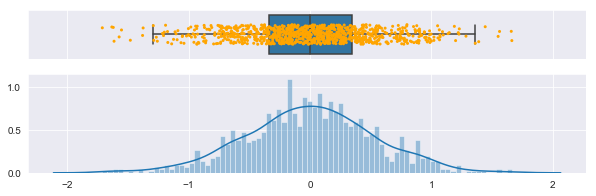

Mean: -3.03e-15


In [35]:
print('Residuals')
res = LR_results.resid
represent_distribution(res)
print('Mean: {:.2e}'.format(res.mean()))

> The histogram of the residuals looks like it follows the normal distribution with zero-mean. To check the assumption on the normal distribution we will run Kolmogorov-Smirnov goodness-of-fit test.

In [48]:
print('Kolmogorov-Smirnov test for residuals.')
print('H0: res ~ Normal')
print('H1: res !~ Normal')
_, pvalue = stats.kstest(res/res.std(), 'norm')
print('p-value: {:.2f}'.format(pvalue))

Kolmogorov-Smirnov test for residuals.
H0: res ~ Normal
H1: res !~ Normal
p-value: 0.85


> With the p-value 0.85 we do not reject the hypothesis of normal distributed residuals. Therefore computing CI is reasonable.

## 6.

Many of the variable appear insigniﬁcant and we should ﬁnd the smallest model, which still has a good explanatory power. Choose this model using stepwise model selection (either based on the tests for $R^2$ or using AIC/BIC). Pick up the last step of the model selection procedure and explain in details how the method/approach works (or is implemented in your software). Work with this model in all the remaining steps.

In total 14 regressors: ['address', 'age', 'churn', 'ed_college', 'ed_highschool', 'ed_postgr', 'ed_somecollege', 'employ', 'gender', 'log_income', 'marital', 'retire', 'tenure', 'wire_not_used']

The best model (forward selection):
> In terms of R^2_adj (11):
['tenure', 'retire', 'marital', 'ed_college', 'ed_highschool', 'ed_somecollege', 'address', 'churn', 'gender', 'log_income', 'age']


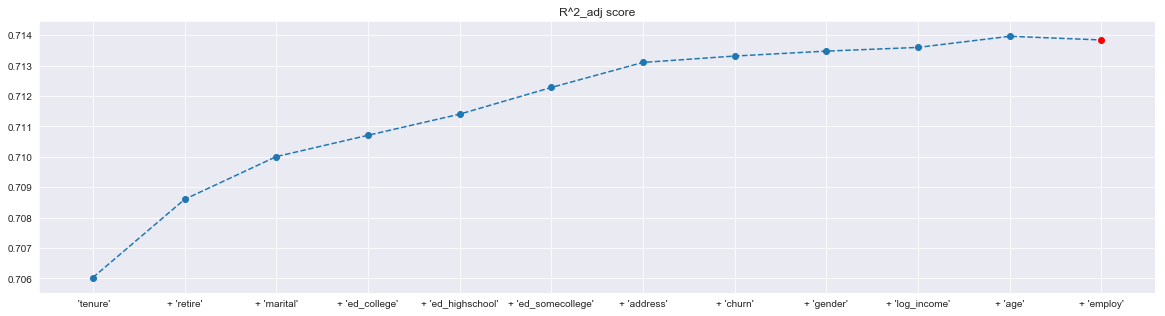

> In terms of AIC (7):
['tenure', 'retire', 'marital', 'ed_college', 'ed_highschool', 'ed_somecollege', 'address']


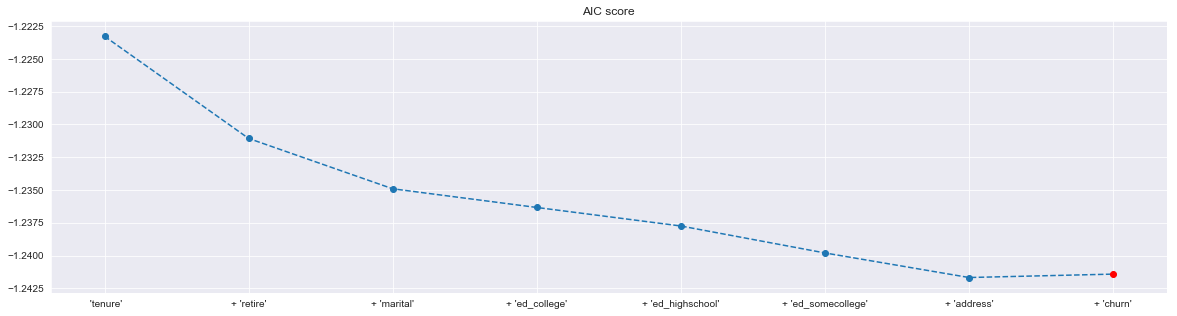

> In terms of BIC (2):
['tenure', 'retire']


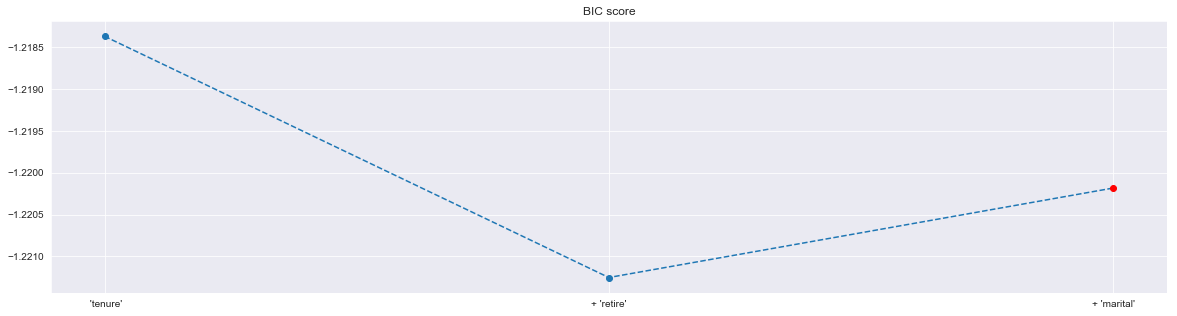

In [147]:
mpl.rcParams['figure.figsize'] = (20,5)
print('In total {} regressors: {}'.format(len(regressors), regressors))

def forward_selection(X, y, regressors, score_type, verbose=False, plot=True):
    score_fn = R_squared_adj if score_type == 'R^2_adj' else AIC if score_type == 'AIC' else BIC 
    regressors_selected, regressors_left = [], regressors.copy()
    scores_selected = []
    best_score = np.inf if score_type in ('AIC', 'BIC') else -np.inf
    score = best_score
    while regressors_left != [] and score==best_score:
        regressor_score = []
        for regressor in regressors_left:
            X_selected = X.loc[:, regressors_selected+[regressor]]
            LR = linear_model.LinearRegression()
            LR.fit(X_selected, y)
            y_hat = LR.predict(X_selected)
            s = score_fn(y, y_hat, len(X_selected.columns))
            regressor_score.append(s)
            if verbose:
                print(regressors_selected+[regressor],': {:.3f}'.format(s))
        i = np.argmin(regressor_score) if score_type in ('AIC', 'BIC') \
            else np.argmax(regressor_score)
        score = regressor_score[i]
        condition = (score < best_score) if score_type in ('AIC', 'BIC') \
                    else (score > best_score)
        if condition:
            if verbose:
                print('> {} is chosen with score {}'.format(regressors_left[i], score))
            best_score = score 
            regressors_selected.append(regressors_left[i])
            scores_selected.append(score)
            del regressors_left[i]
    print('> In terms of {} ({}):\n{}'.format(score_type, len(regressors_selected), regressors_selected))
    if plot:
        xs = regressors_selected+[regressors_left[i]]
        xs = ['{} \'{}\''.format('' if i==0 else '+', x) for i, x in enumerate(xs)]
        plt.plot(xs, scores_selected+[score], '--')
        plt.scatter(xs[:-1], scores_selected)
        plt.scatter(xs[-1], score, color='r', zorder=10)
        plt.title('{} score'.format(score_type))
        plt.show()
    return regressors_selected

print('\nThe best model (forward selection):')
forward_selection(X, y, regressors, 'R^2_adj')
regressors_selected = forward_selection(X, y, regressors, 'AIC')
forward_selection(X, y, regressors, 'BIC');

> The result of forward model selection using AIC was chosen as a middle ground. The selected regressors are: `tenure`, `retire`, `marital`, `ed_college`, `ed_highschool`, `ed_somecollege`, `address`.

In [148]:
intervals_regressors = list(set(regressors_selected).intersection(set(intervals_regressors)))
other_regressors = list(set(regressors_selected).intersection(set(other_regressors)))
X = X.loc[:, regressors_selected]
X_ = sm.add_constant(X)
LR = sm.OLS(y, X_)
LR_results = LR.fit()
print(LR_results.summary())

                            OLS Regression Results                            
Dep. Variable:            log_longmon   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     355.7
Date:                Tue, 26 Feb 2019   Prob (F-statistic):          2.36e-265
Time:                        13:38:25   Log-Likelihood:                -790.60
No. Observations:                1000   AIC:                             1597.
Df Residuals:                     992   BIC:                             1636.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1508      0.038     -3.

## 7.

Sometimes data contains outliers which induces bias in the parameter estimates. Check for outliers using Cook’s distance and leverage. Have a closer look at the observation with the highest leverage (regardless if it is classiﬁed as an outlier or not). What makes this observation so outstanding (you may have a look at Box-plots for interval scaled variables or at the frequencies for binary/ordinal variables?

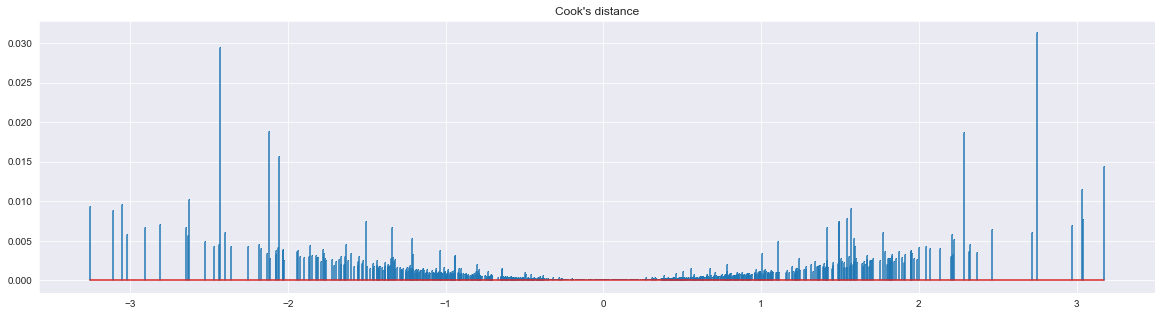

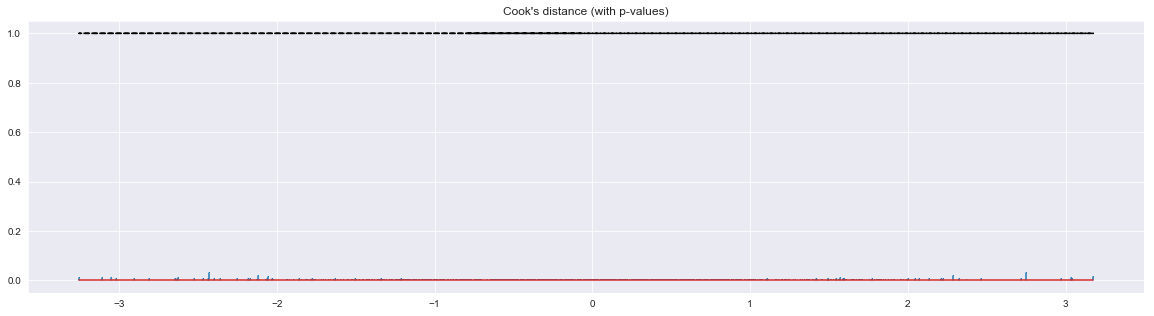

In [207]:
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(LR_results).summary_frame()
pvals = LR_results.get_influence().cooks_distance[1]
plt.stem(influence.standard_resid, influence.cooks_d, markerfmt=",")
plt.title('Cook\'s distance')
plt.show()
plt.stem(influence.standard_resid, influence.cooks_d, markerfmt=",")
plt.plot(influence.standard_resid, pvals, 'k--')
plt.title('Cook\'s distance (with p-values)')
plt.show()

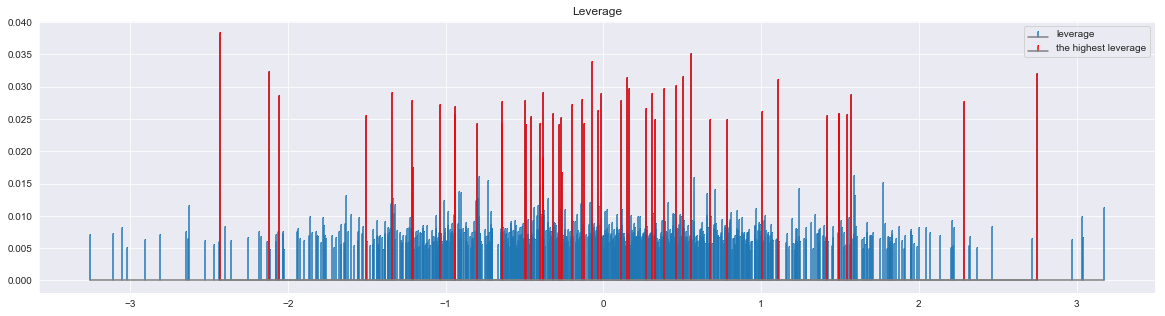

In [216]:
plt.title('Leverage')
leverage = influence.hat_diag
plt.stem(influence.standard_resid, leverage, markerfmt=",", basefmt='gray')

n = 50
ind = leverage.index[(-leverage).argsort()][:n]
plt.stem(influence.standard_resid.loc[ind], leverage.loc[ind],
         markerfmt="r,", linefmt='r', basefmt='gray')

plt.legend(['leverage', 'the highest leverage'])
plt.show()

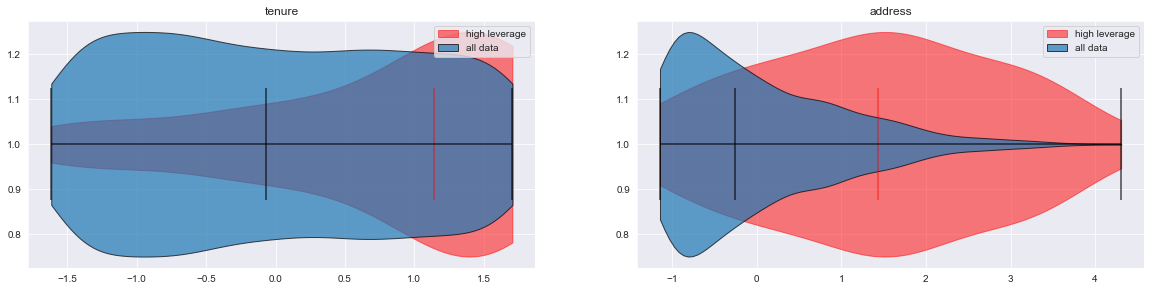

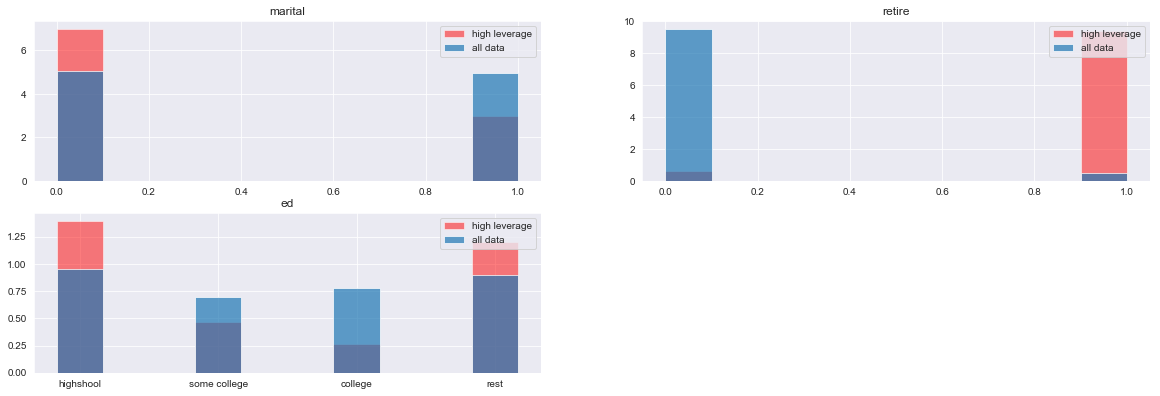

In [458]:
temp = X.copy()
temp['HighLeverage'] = False
temp.loc[ind, 'HighLeverage'] = True
temp['ed'] = (1*temp.ed_highschool + 2*temp.ed_somecollege + 3*temp.ed_college + 3) % 4

mpl.rcParams['figure.figsize'] = (20,10)
for i, r in enumerate(intervals_regressors):
    plt.subplot(len(intervals_regressors)//2+1, 2, i+1)
    plt.title(r)
    p1 = plt.violinplot(temp[temp['HighLeverage']==True][r],
                           showextrema=False, showmedians=True, vert=False)
    p2 = plt.violinplot(temp[r],
                   showextrema=True, showmedians=True, vert=False)
    for pc in p1['bodies']+[p1['cmedians']]:
        pc.set_facecolor('red')
        pc.set_edgecolor('red')
        pc.set_alpha(0.5)
    for pc in p2['bodies']+[p2['cmedians']] + [p2['cbars']]+ [p2['cmins']]+ [p2['cmaxes']]:
        pc.set_facecolor('C0')
        pc.set_edgecolor('k')
        pc.set_alpha(0.7)
    p1['bodies'][0].set_label('high leverage')
    p2['bodies'][0].set_label('all data')
    plt.legend()
plt.show()

for i, r in enumerate([r for r in other_regressors + ['ed'] if r[:3]!='ed_']):
    plt.subplot(len(other_regressors)//2+1, 2, i+1)
    plt.title(r)
    plt.hist(temp[temp['HighLeverage']==True][r], alpha=0.5, density=True, color='r')
    plt.hist(temp[r], alpha=0.7, density=True)
    plt.legend(['high leverage', 'all data'], loc=1)
    if r=='ed':
        plt.xticks([0.15,1.05,1.95,2.85], ['highshool', 'some college', 'college', 'rest'])
plt.show()

> One can se from the distributions that the observations with the highest leverage have characteristics such as high tenure and long period at the current address. It is more often when the 'outlier' person is single, gets lower/no education and almost all of them are retired,

## 8.

Frequently data is missing. Pick up 5 rows in the data set and delete the value for address. Implement at least two approaches to ﬁll in these values. Write down the corresponding formulas/model and give motivation for your approach. If you use standard routines then check how exactly the data imputation is implemented. How would you proceed if the value of the binary variable `retire` is missing? Implementation is not required.

In [480]:
# Missing completely at random
X_miss = X.copy()
np.random.seed(100)
m = 5
ind_to_delete = np.random.randint(1,len(X_miss)+1, size=m)
X_miss.loc[ind_to_delete,'address'] = np.nan
X_miss = get_normalized_X_y(X_miss, y, intervals_regressors)[0]
X_miss.loc[ind_to_delete,:]

,tenure,retire,marital,ed_college,ed_highschool,ed_somecollege,address
521,0.490360,0,1,0,0,0,NaN
793,0.256276,0,1,0,1,0,NaN
836,-1.195048,0,1,0,1,0,NaN
872,1.613966,0,0,0,0,0,NaN
856,0.677628,0,0,0,0,0,NaN


> 1. Drop the rows with missing data:

In [481]:
X1 = X_miss.drop(ind_to_delete, 0)
y1 = y.drop(ind_to_delete, 0)

LR1, beta_df1 = get_LR_beta(X1, y1, True)

LR scores:
R^2 = 0.715
R^2_adj = 0.711
AIC = -1.229
BIC = -1.160


> 2. Hot imputation: for each observation with missing address get the `k=10` closest (by variables except `address`) observations without missing address and randomly choose one of them to replace missing value:

In [483]:
np.random.seed(100)
X2 = X_miss.copy()
k = 10
for i in range(m):
    other_values = list(X2.loc[ind_to_delete[i], :][other_regressors])
    X2[np.min(X2[other_regressors] - other_values == 0, 1)]

    intervals_regressors_ = sorted(list(set(intervals_regressors).difference({'address'})))
    intervals_values = list(X2.loc[ind_to_delete[i], :][intervals_regressors_])
    aux_df = (np.square(X2[intervals_regressors_] - intervals_values)).drop(ind_to_delete, 0)
    aux_df['mean'] = np.mean(aux_df[intervals_regressors_], 1)
    ind_to_replace = np.random.choice(aux_df.sort_values(by='mean').head(k).index)
#     print(ind_to_delete[i], '<-', ind_to_replace)
    X2.loc[ind_to_delete[i], 'address'] = X2.loc[ind_to_replace,'address']

LR2, beta_df2 = get_LR_beta(X2, y, True)

LR scores:
R^2 = 0.715
R^2_adj = 0.711
AIC = -1.227
BIC = -1.158


> 3. Mean imputation: replace missing values with the mean of the variable:

In [484]:
X3 = X_miss.copy()
X3.loc[ind_to_delete, 'address'] = np.mean(X3['address'])
LR3, beta_df3 = get_LR_beta(X3, y, True)

LR scores:
R^2 = 0.715
R^2_adj = 0.711
AIC = -1.227
BIC = -1.159


> 4. Regression imputation: replace missing values with the forecast using the Linear Regression model with `address` as a dependent variable, and all the others (except actual regressand `log_longmon`) as regressors:

In [485]:
X4 = X_miss.copy()

XX = X_miss.drop(ind_to_delete, 0).drop('address',1)
Xy = X_miss.drop(ind_to_delete, 0)['address']

XLR, _ = get_LR_beta(XX, Xy)
X4.loc[ind_to_delete, 'address'] = XLR.predict(X_miss.loc[ind_to_delete,:].drop('address',1))
LR4, beta_df4 = get_LR_beta(X4, y, True)

LR scores:
R^2 = 0.715
R^2_adj = 0.711
AIC = -1.227
BIC = -1.159


> All the methods seem to work well. Droping 5 rows with missing values may not affect the result too much but in case of more frequent missing values we may loose useful information since it may be contained  in the droped rows. If the value of the binary variable `retire` is missing I would suggest to use hot imputation or median imputation or forecast using the logistic regression model. 

## 9.

Now we look at the model assumptions. The variable `address` seems to be very significant. However, if we look at the residuals we observe that the variance of the residuals is rather diﬀerent for diﬀerent values of address. Run the Bartlett’s test and compute the FGLS estimators assuming an exponential relationship between the variance of residuals and address. Compare the results with the original model. Explain the advantages of the (F)GLS estimation.

Variable `address`
Number of observations: 1000


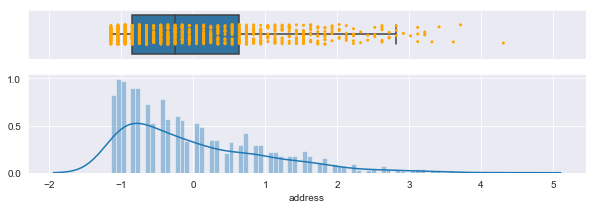

We will drop observations with address value > 2.87 (due to a small number of observations)


In [633]:
represent_distribution(X['address'], varname='address')
q25, q75 = p_quantile(X.address, 0.25), p_quantile(X.address, 0.75) 
upper_bound = q75 + 1.5*(q75 - q25)
print('We will drop observations with address value > {:.2f} (due to a small number of observations)'.format(upper_bound)) 

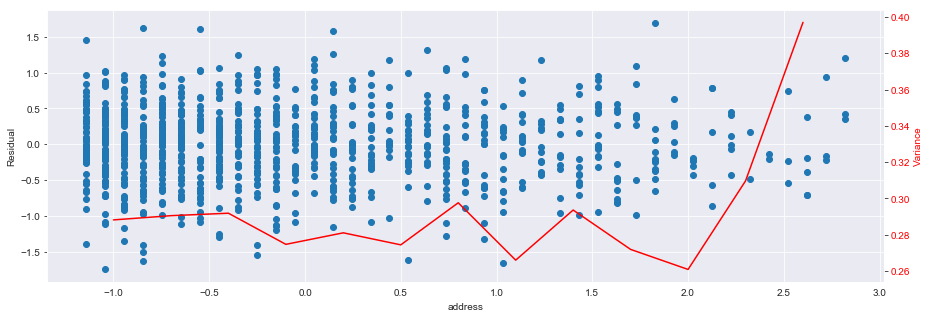

In [639]:
mpl.rcParams['figure.figsize'] = (15,5)

temp = X[['address']]
temp['resid'] = LR_results.resid
temp = temp[temp.address<upper_bound]

vs = []
delta = 0.3
l = np.arange(-1,3,delta)
for i,j in zip(l, np.arange(0,4,delta)):
    v = temp[temp.address > i][temp.address < j].resid.var()
    vs.append(v)

fig, ax1 = plt.subplots()
ax1.scatter(temp.address, temp.resid, zorder=10)
ax1.set_ylabel('Residual')
ax1.set_xlabel('address')

ax2 = ax1.twinx()
ax2.grid('off')
ax2.plot(l,vs, 'r', label=' of residuals')
ax2.set_ylabel('Variance', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.show()

In [657]:
print('Bartlett\'s Test:')
print('H0: sigma_1^2 = ... = sigma_2^2')
print('H1: sigma_i^2 != sigma_j^2 for at least one pair (i,j)')
stats.bartlett(*[r[1].values for r in temp.groupby('address').resid])

Bartlett's Test:
H0: sigma_1^2 = ... = sigma_2^2
H1: sigma_i^2 != sigma_j^2 for at least one pair (i,j)


BartlettResult(statistic=38.69457145789063, pvalue=0.5289947719634349)

> With the p-value is 0.529 we can not reject the null hypothesis. So we don't have enough arguments to reject that the variances are the same.

In [692]:
multiplier = sm.OLS(np.log(temp.resid**2), sm.add_constant(temp.address)).fit().params.address
print('The LR result: sigma_i^2 = sigma^2 * exp({:.3f} * address_i)\n'.format(multiplier))

w = np.exp(multiplier * X.address)

LR_OLS = sm.OLS(y, X_)
LR_OLS_results = LR_OLS.fit()
print(LR_OLS_results.summary())
print()

LR_FGLS = sm.GLS(y, X_, weights=w)
LR_FGLS_results = LR_FGLS.fit()
print(LR_FGLS_results.summary())

The LR result: sigma_i^2 = sigma^2 * exp(0.098 * address_i)

                            OLS Regression Results                            
Dep. Variable:            log_longmon   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     355.7
Date:                Tue, 26 Feb 2019   Prob (F-statistic):          2.36e-265
Time:                        17:25:40   Log-Likelihood:                -790.60
No. Observations:                1000   AIC:                             1597.
Df Residuals:                     992   BIC:                             1636.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

> The advantage of the feasible GLS is that the parameter estimator is more efficient than that of OLS. This advantage is seen only when the weights of the error covariance matrix are correlated with data. If the weights are known, we have the best linear unbiased estimator. In our case and more often it is unknown. Still with the  estimated weights (FGLS) we may get more efficient parameters.
>
> Here we got identical results which is expectable since with the Bartlett’s test we couldn't reject the hypothesis that the variances are the same.

## 10.

Compute the White estimator of covariance matrix of the OLS estimators. Run the t-tests and compare the results with the original model. Explain the advantages of the White estimator for the variance.

In [705]:
print(LR_OLS.fit().summary())
print()
print(LR_OLS.fit(cov_type='HC0').summary())

                            OLS Regression Results                            
Dep. Variable:            log_longmon   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     355.7
Date:                Tue, 26 Feb 2019   Prob (F-statistic):          2.36e-265
Time:                        17:32:12   Log-Likelihood:                -790.60
No. Observations:                1000   AIC:                             1597.
Df Residuals:                     992   BIC:                             1636.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1508      0.038     -3.

> The white estimator corrected the confidence intervals since it is computed based on the variance of the parameters — white estimator of the covariance matrix based on the residuals and is used in computing the variance of the parameters. Also in the significance tests the statistic values changed and the p-values increased, but not significantly.